<center>

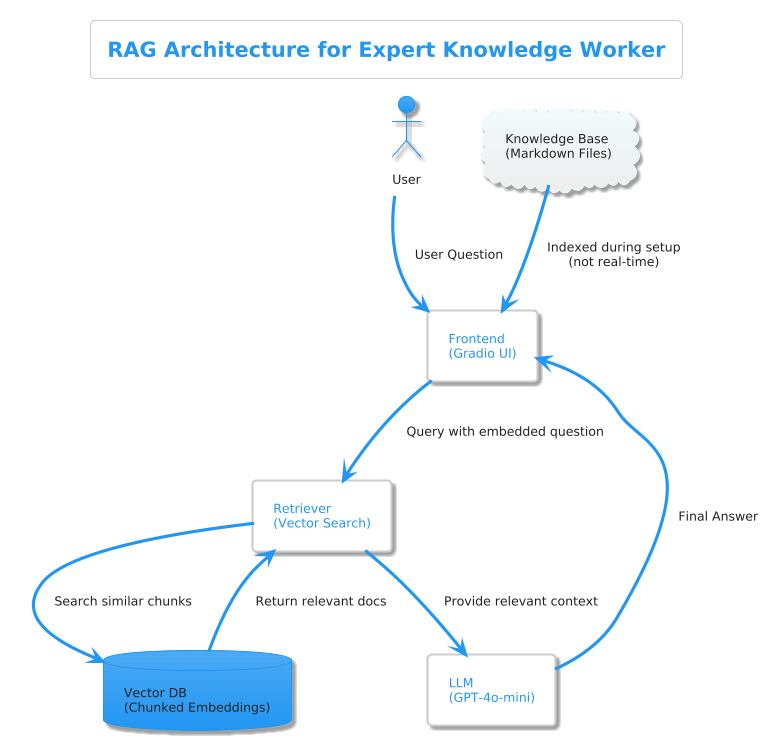

</center>

In [29]:
import os
import glob
from dotenv import load_dotenv

# LangChain
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain import HuggingFaceHub

# Gradio for UI
import gradio as gr

In [30]:
# ─── Configuration ─────────────────────────────────────────────────────────────

load_dotenv(override=True)
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HUGGINGFACE_TOKEN")

# The open-source LLM and embedding models you want to use
LLM_MODEL = "mistralai/Mixtral-8x7B-Instruct-v0.1"
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"

# Where to persist your Chroma vector database
DB_DIR = "vector_db"


In [31]:
# ─── 1) Load & split your documents ────────────────────────────────────────────

folders = glob.glob("knowledge-base/*")
loader_kwargs = {"encoding": "utf-8"}

docs = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(
        folder,
        glob="**/*.md",
        loader_cls=TextLoader,
        loader_kwargs=loader_kwargs
    )
    for d in loader.load():
        d.metadata["doc_type"] = doc_type
        docs.append(d)

splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

Created a chunk of size 1088, which is longer than the specified 1000


In [33]:
# ─── 2) Build (or rebuild) the vector store ────────────────────────────────────

embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)

# If you’ve run this before, delete the old collection
if os.path.exists(DB_DIR):
    Chroma(persist_directory=DB_DIR, embedding_function=embeddings).delete_collection()

vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings,
    persist_directory=DB_DIR
)

In [34]:
# ─── 3) Set up the HF‐backed LLM & the RAG chain ───────────────────────────────

# This will call the HuggingFace Inference API under the hood
hf_llm = HuggingFaceHub(
    repo_id=LLM_MODEL,
    model_kwargs={"temperature": 0.7, "max_new_tokens": 512}
)

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
retriever = vectorstore.as_retriever()

rag_chain = ConversationalRetrievalChain.from_llm(
    llm=hf_llm,
    retriever=retriever,
    memory=memory
)


C:\Users\deluc\AppData\Local\Temp\ipykernel_672\1707835350.py:4: LangChainDeprecationWarning: The class `HuggingFaceHub` was deprecated in LangChain 0.0.21 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  hf_llm = HuggingFaceHub(
C:\Users\deluc\AppData\Local\Temp\ipykernel_672\1707835350.py:9: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)


In [35]:
# ─── 4) Wire it up in Gradio ───────────────────────────────────────────────────

def chat_fn(user_message, history):
    resp = rag_chain.invoke({"question": user_message})
    return resp["answer"]

gr.ChatInterface(fn=chat_fn, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
